<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 8

In this class, we will formalize how we actualy make a scientific hypothesis and test it. 

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 8.0 Overview of Learning Objectives

In this lecture we will explore the following objectives:

- What is a measurment?
- Bayes Thereom
- Bayesian vs Frequentists
- Nuisance Parameters
- Hypothesis test
- $\chi^2$ test
- KS-test
- Likelihood test

<br>
<!--end-block-->

## 6.7 Convolutions

Convlutions are a critical component of evey good statistical analysis. Its a way to multiply distributions together. 
Lets build convlutions up by scratch and then go from there. 

The core concept of a convolution is that you are effectively multiplying distributions. Given two functions $f(x)$ and $g(x)$, we can define convolutions by 
\begin{eqnarray}
(f*g)(z) &=& \int^{\infty}_{-\infty} f(z-t)g(t)dt
\end{eqnarray}
For data analysis, we usually think about this in the context of probability distribuitons $g$ and $f$. From here, we construct a new probability distribution $(f*g)$. Anyway, lets take a look at how it works. 

To do this, lets first define some functions to convolve. 

In [18]:
#First lets define a triangular distribution
def triangle(x,mean=5):
    Norm=mean*mean
    val=np.where(x <= mean,np.maximum(x,np.zeros(len(x))), np.maximum(2*mean-x,np.zeros(len(x))))
    return val/Norm

#Now define the gaussian
def gaussian(x,mean=0,sigma=1):
    return 1./(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sigma**2)) 


In [19]:
#Now lets do a convolution by hand
def convolve(f1,f2,x,sigma=1,iMin=-10,iMax=10,iN=2000):
    step=(iMax-iMin)/iN
    pInt=0
    for i0 in range(iN):
            pX   = np.repeat(i0*step+iMin,len(x))
            pVal = f1(x-pX,sigma=sigma)*f2(pX)
            pInt += pVal*step
    return pInt

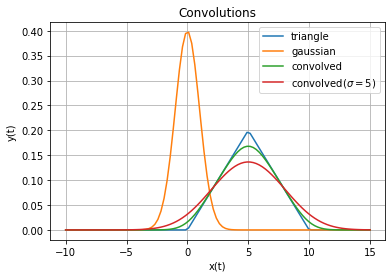

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
tri_out=triangle(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,triangle,x_in)
conv2_out=convolve(gaussian,triangle,x_in,sigma=2)

ax.plot(x_in,tri_out,label='triangle')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=5$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

### challenge question

What does $f(x)=\sin(x)$ convoled with a gaussian look like? How does it change by the resolution of the gaussian?

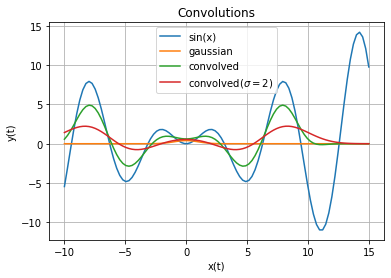

In [24]:
def func(x):
    return np.sin(x)*x

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
func_out=func(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,func,x_in)
conv2_out=convolve(gaussian,func,x_in,sigma=2)

ax.plot(x_in,func_out,label='sin(x)')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.plot(x_in,conv2_out,label='convolved($\sigma=2$)')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

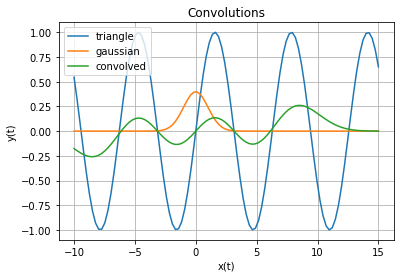

In [25]:
#answer
def func(x):
    return np.sin(x)*x

#now lets plot
fig, ax = plt.subplots()
x_in=np.linspace(-10, 15, 100)
sin_out=sin(x_in)
gaus_out=gaussian(x_in)
conv_out=convolve(gaussian,sin,x_in,sigma=2)


ax.plot(x_in,sin_out,label='triangle')
ax.plot(x_in,gaus_out,label='gaussian')
ax.plot(x_in,conv_out,label='convolved')
ax.set(xlabel='x(t)', ylabel='y(t)',title='Convolutions')
ax.grid()
plt.legend()
plt.show()

## 8.1 What is a measurment? 

What is a measurement? 

Lets say we have a measurement of some parameter $x$, and this meausurement behaves like a gaussian about some point with width $\sigma=1$. Lets write out this meausrement.  

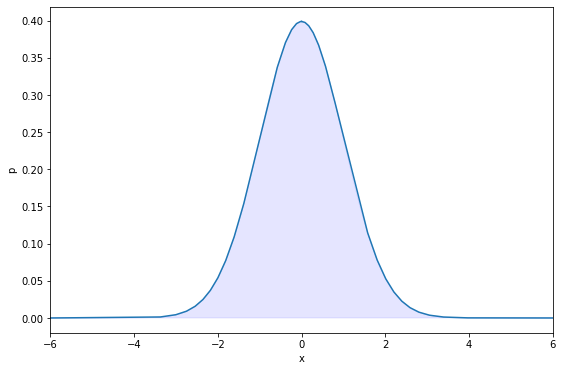

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Our measurement probability
def gaus(mu=0,sigma=1): 
    x = np.arange(-10, 10, 0.001)
    y = stats.norm.pdf(x,mu,sigma)
    return x,y

#a quick plot of what we expect the measurement to be
def plotgaus():
    x,y=gaus(0,1)
    fig, ax = plt.subplots(figsize=(9,6))
    plt.style.use('fast')
    ax.plot(x,y)
    ax.fill_between(x,y,0, alpha=0.1, color='b')
    ax.set_xlim([-6,6])
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    plt.show()

plotgaus()

This preconceived distribution about how our measurement will behave is known as a prior. Now lets say we perform this measurement, but our observed measurement is not actually at the point we expect it to be. What if, for example our measurement is at $x=2$ what woud be the likelihood of this occuring or not occuring. 

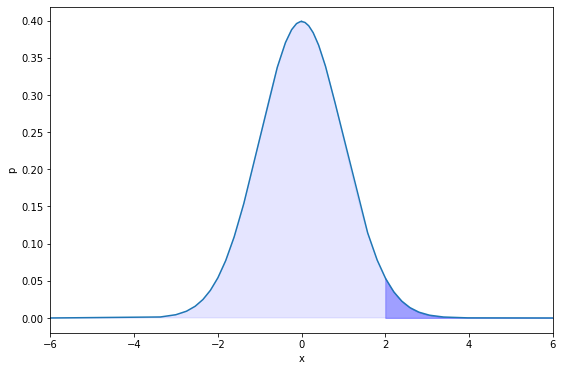

In [26]:
def gaus(mu=0,sigma=1,meas=2): 
    x = np.arange(-10, 10, 0.001)
    xmeas = np.arange(meas, 10, 0.001)
    y = stats.norm.pdf(x,mu,sigma)
    ymeas = stats.norm.pdf(xmeas,mu,sigma)
    return x,y,xmeas,ymeas

def plotgaus():
    x,y,xmeas,ymeas=gaus(0,1,2)
    fig, ax = plt.subplots(figsize=(9,6))
    plt.style.use('fast')
    ax.plot(x,y)
    ax.fill_between(x,y,0, alpha=0.1, color='b')
    ax.fill_between(xmeas,ymeas,0, alpha=0.3, color='b')
    ax.set_xlim([-6,6])
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    plt.show()
plotgaus()

From the above, observed measurement. It is clear that this distribution has a large deviation from what we actually expected to observe. The key question here that we would like to understand: Is this a statistical fluctation, or is this something we did not expect?  

Understanding if this is something we do not expect is the focus of this lecture. Lets now imagine that we perform this measurement a number of time, say 10 times, and it all comes up away from our expectation, or perhaps 1000 times, what do we thing?

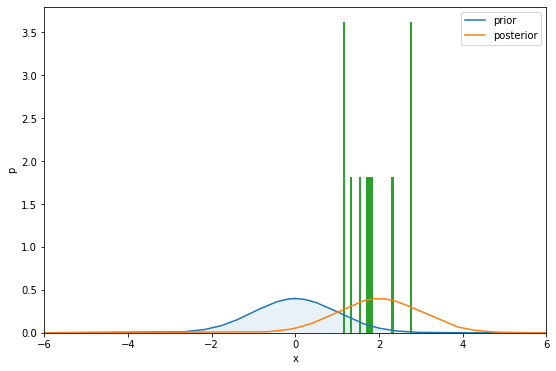

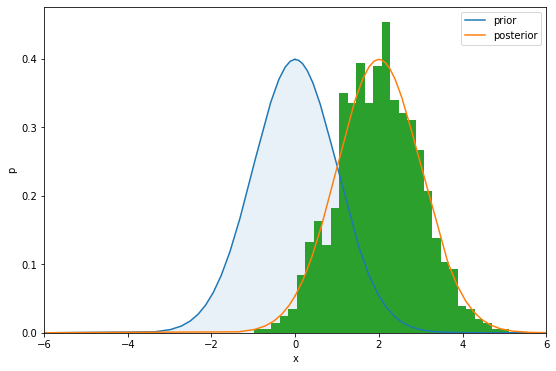

In [27]:
def gaus(mu=0,sigma=1): 
    x = np.arange(-10, 10, 0.001)
    y = stats.norm.pdf(x,mu,sigma)
    return x,y

def plotGausSample(iZ,iSample):
    plt.style.use('fast')
    fig, ax = plt.subplots(figsize=(9,6))
    #sample
    samples = np.random.normal(iZ,1,iSample)
    x,y=gaus(iZ,1)
    #
    xs,ys=gaus(0,1)
    ax.plot(xs,ys,label='prior')
    ax.plot(x,y,label='posterior')
    count, bins, ignored = plt.hist(samples, 30, density=True)
    ax.fill_between(xs,ys,0, alpha=0.1)
    ax.set_xlim([-6,6])
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.legend()
    plt.show()

plotGausSample(2,10)
plotGausSample(2,1000)

Now we have two results, we have a prior (aka a guess) of what we though the data would look like and a posterior for what we actually observe the data. These two observations yield two different ways to interpret the data. 

**Bayesian** It is possible to create a model of everything and within your model you can explain all random phenomena. As we take more data, we can fine tune our model to be ever more predictive. 

**Frequentist** The data guides our model. We can use what we observe in the data to explain how we will observe these phenomena in the future. 

### 8.2 Bayes Thereom

To understand Bayes theorem, lets define a bunch of terms, first we would like the define the probability of a hypothesis happening. We can write this probability as $P\left(\mathcal{H}\right)$, this is the probability of the hypothesis happening given a prior for how we expect the distribution to behave. To put a concrete label to this, lets consider that you are on a game show similar to the "Monty Hall" game show of the 1960s. You have 3 doors and there is a car behind one of the doors. The car is placed randomly, what is your original $P\left(\mathcal{H}\right)$?

\begin{eqnarray}
P(\mathcal{H}=\rm{door~1}) & = & \frac{1}{3} \\
P(\mathcal{H}=\rm{door~2}) & = & \frac{1}{3} \\
P(\mathcal{H}=\rm{door~3}) & = & \frac{1}{3} 
\end{eqnarray}

Now everything changes when you open one of the doors. In that instance your knowledge of what happens changes completely since you now have knowledge of what is behind which door. In the case of this, there are two results. The first result is that there is a car behind the door, great! In the second case, you know that the door that was opened is empty. So the question is what do you.  However, in the Monty Hall problem. Monty will mix things up by opening a door that does not have a car, and then asking you to stay with you original choice, or to switch. What do you do? 

Let's define $P\left(\mathcal{D}\right)$ as the probability of an instance of the data happening, and furthemore defining

\begin{eqnarray}
 P\left(\mathcal{H} | \mathcal{D} \right) & = & \rm{probability~of~a~hypothesis~given~data} \\
 P\left(\mathcal{D} | \mathcal{H} \right) & = & \rm{probability~of~data~given~a~hypothesis} \\
\end{eqnarray}

Let's say you choose door 1, and Monty opens door two. We can write down the probability that Monty will open door 2
\begin{eqnarray}
P(\rm{open~2}|\mathcal{H}=\rm{car~at~door~1}) & = & \frac{1}{2} \\
P(\rm{open~2}|\mathcal{H}=\rm{car~at~door~2}) & = & 0 \\
P(\rm{open~2}|\mathcal{H}=\rm{car~at~door~3}) & = & 1 
\end{eqnarray}

If you chose correctly, the first time, then Monty has a 50% chance of choosing door 2 or 3, and both doors will not contain a car. If you did not choose correctly the first time, then Monty will for sure open a specific door, and in this scenario you know for sure that behind the other door that Monty did not choose is the car. So given this perspective do you switch or stay? Lets write out the probabilities again, remember when you start you have a $\frac{1}{3}$ chance of choosing correctly, and a $\frac{2}{3}$ chance of choosing incorrectly. 

\begin{eqnarray}
P(\mathcal{H}=\rm{car~at~door~1}|\mathcal{D}=\rm{open~2}) & = & \frac{1}{3} \\
P(\mathcal{H}=\rm{car~at~door~2}|\mathcal{D}=\rm{open~2}) & = & 0 \\
P(\mathcal{H}=\rm{car~at~door~3}|\mathcal{D}=\rm{open~2}) & = & \frac{2}{3}  
\end{eqnarray}

or more generically we can write out:
\begin{equation}
P(\mathcal{H}=\rm{car~at~door~1}|\mathcal{D}=\rm{open~2}) = \frac{P(\mathcal{D}=\rm{open~2}|\mathcal{H}=\rm{car~at~door~1})P(\mathcal{H}=\rm{door~1})}{\rm{all~combinations}}
\end{equation}
or in other words

\begin{equation}
P(\mathcal{H}=\rm{car~at~door~1}|\mathcal{D}=\rm{open~2}) = \frac{P(\mathcal{D}=\rm{open~2}|\mathcal{H}=\rm{car~at~door~1})P(\mathcal{H}=\rm{door~1})}{P\left(\mathcal{D}=\rm{car~at~door~1}\right)+P\left(\mathcal{D}=\rm{car~at~door~2}\right)+P\left(\mathcal{D}=\rm{car~at~door~3}\right)}
\end{equation}

More generically, we can write this as what is known as Bayes theorem
\begin{equation}
 P\left(\mathcal{H} | \mathcal{D} \right) =  \frac{P\left(\mathcal{D} | \mathcal{H} \right)P(\mathcal{H})}{P(\mathcal{D})} 
\end{equation}

We can also relabel these terms as: 
\begin{eqnarray}
 P\left(\mathcal{H} | \mathcal{D} \right) & = & \rm{Posterior} \\
 P\left(\mathcal{D} | \mathcal{H} \right) & = & \rm{Likelihood} \\
 P\left(\mathcal{H} \right) & = & \rm{Prior} \\
 P\left(\mathcal{D} \right) & = & \rm{Normalizer(all~possibilities)} 
\end{eqnarray} 

The Posterior is our observed result, the Prior is our initial guess, the likelihood is what actually we observe, and finally the bottom term, the normalizer, is to ensure that our probabilities integrate to $1$ (aka, we have covered, and only covered, all possibilities).  As a general rule of thumb, the way to remember this is

\begin{equation}
 \rm{posterior} \propto \rm{likelihood} \times \rm{prior}
\end{equation}

Given Bayes theorem, lets go back to our original measurement. In that case, we had two normal distributions, a posterior about two, and a prior about zero. How do we connect these two? 

\begin{equation}
 P\left(\mathcal{H} | \mathcal{D} \right) =  \frac{P\left(\mathcal{D} | \mathcal{H} \right)P(\mathcal{H})}{P(\mathcal{D})} \\
\mathcal{N}(x,\mu=2,1) = \frac{P\left(\mathcal{D} | \mathcal{H} \right)}{P(\mathcal{D})}\mathcal{N}(x,\mu=0,1) \\
P\left(\mathcal{D} | \mathcal{H} \right) = \frac{\mathcal{N}(x,\mu=2,1)}{\mathcal{N}(x,\mu=0,1)} P(\mathcal{D}) 
\end{equation}

Since $P(\mathcal{D})$ is just a constant to ensure that our resulting probability is normalized, we can pretty easily compute the likelihood in our first example. Lets plot it. 


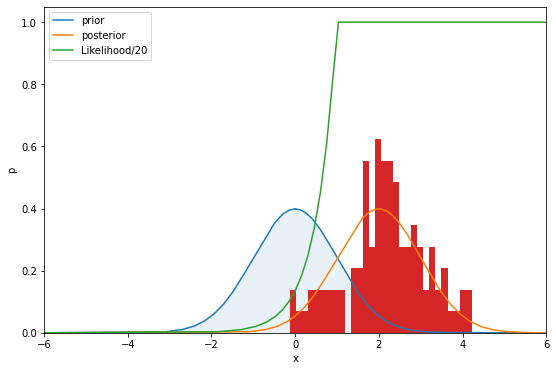

In [30]:
def plotGausSampleLike(iZ,iSample):
    plt.style.use('fast')
    fig, ax = plt.subplots(figsize=(9,6))
    #Sample
    samples = np.random.normal(iZ,1,iSample)
    x,y=gaus(iZ,1)
    #prior
    xs,ys=gaus(0,1)
    #likelihood
    yratio=np.minimum(y/ys,1.)
    #plot
    ax.plot(xs,ys,label='prior')
    ax.plot(x,y,label='posterior')
    ax.plot(x,yratio,label='Likelihood/20')
    count, bins, ignored = plt.hist(samples, 30, density=True)
    ax.fill_between(xs,ys,0, alpha=0.1)
    ax.set_xlim([-6,6])
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.legend()
    plt.show()

plotGausSampleLike(2,100)

As you can see the likelihood shoots up, and in fact shoots up above 1, this means that our liklelihood is unphysical, and we are not capturing our physics, or more imporantly, this means that **our prior is wrong**. Whats the right prior in this scenario? 

Lets tweak our prior to have a large sigma $\mathcal{N}(\mu=0,\sigma=2)$

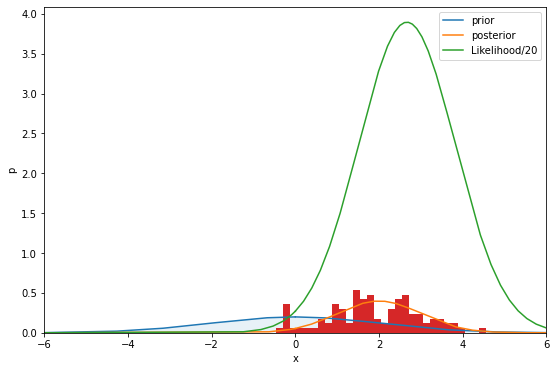

In [32]:
def plotGausSampleLike(iZ,iSample,iSigMax):
    plt.style.use('fast')
    fig, ax = plt.subplots(figsize=(9,6))
    #ample our posterior
    samples = np.random.normal(iZ,1,iSample)
    x,y=gaus(iZ,1)
    #Sample our prior
    xs,ys=gaus(0,iSigMax) #######<<<<< This is our tweak
    #now compute the likelihood
    yratio=np.minimum(y/ys,20.)
    #pot this stuff
    ax.plot(xs,ys,label='prior')
    ax.plot(x,y,label='posterior')
    ax.plot(x,yratio,label='Likelihood/20')
    count, bins, ignored = plt.hist(samples, 30, density=True)
    ax.fill_between(xs,ys,0, alpha=0.1)
    ax.set_xlim([-6,6])
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.legend()
    plt.show()
    #now return our sampled normal distribution
    return samples
    
samples=plotGausSampleLike(2,100,2)

What have we done?  Essentially, we had previously claimed that our measurement was at zero with uncertainty (expected $\sigma$=1). Now what we have done is made the claim that our uncertainty is way larger. What this has done is lowered our likelihood for something observed to happen to some number that is now not insanely large.  

### Challenge question: 

Consider that we have two gaussians one with mean of 0 and one with mean of 0.1, and both have width 1. In one experiment, we sample it 1000 samples, and in another we sample it 1,000,000 times. What is the max likelihood value of all the observed points? What would the case be if we sampled even more (10M...)? What does this mean about the distributions? 

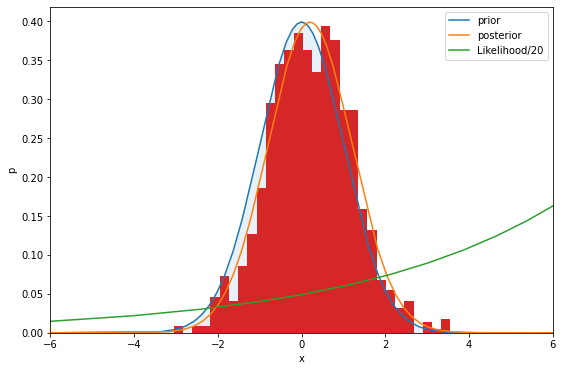

Max: 1000  is  1.997070998717025


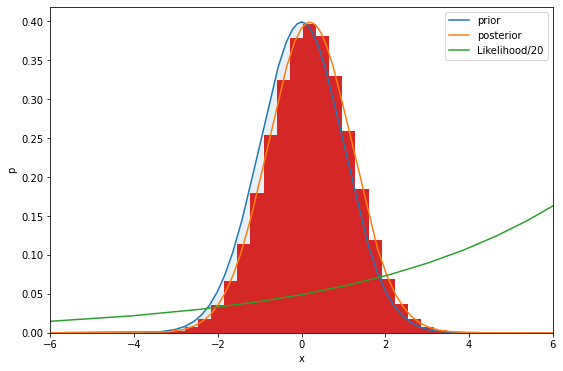

Max: 1000000  is  2.6924293566195283


In [10]:
#solution
def maxlikelihood(isamples,mu1=0.2,sig1=1,mu2=0,sig2=1):
    val=np.max(isamples)#compute the highest sampled gaussian
    #now compute the liklihood of these two
    like=stats.norm.pdf(val,mu1,sig1)/stats.norm.pdf(val,mu2,sig2)
    return like

def maxlike(iN):
    samples=plotGausSampleLike(0.2,iN,1)
    like=maxlikelihood(samples)
    print("Max:",iN," is ",like)

maxlike(1000)
maxlike(1000000)

## 8.3 Bayesian vs Frequentists

Now, this interpretation all comes to a head when we start to think about how we wish to quote our results. If our priors are incorrect, and we continue to progressively take data, at some point our priors are going to be wrong. Dealing with how this is wrong depends on what sort of statistician you are.  Here is a diagram to explain. 

![diagram](bayes_freq.png)

**Frequentist** If I see a data distribution, I can come up with a way to fit it. By getting a good fit, I can explain the next result. 

**Bayesian** I start with a model, by taking more and more measurements, I can improve my model. 

To try to capture these ideas, lets fit this guassian with two separate approaches. 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


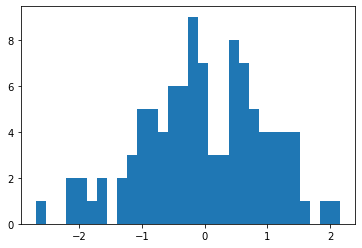

/Users/pharris/Library/Python/3.7/lib/python/site-packages/lmfit/model.py:1850: RuntimeWarning: divide by zero encountered in true_divide
  yerr = 1.0/self.weights
/Users/pharris/Library/Python/3.7/lib/python/site-packages/lmfit/model.py:1956: RuntimeWarning: divide by zero encountered in true_divide
  yerr = 1.0/self.weights
/Users/pharris/Library/Python/3.7/lib/python/site-packages/lmfit/model.py:1850: RuntimeWarning: divide by zero encountered in true_divide
  yerr = 1.0/self.weights
/Users/pharris/Library/Python/3.7/lib/python/site-packages/lmfit/model.py:1956: RuntimeWarning: divide by zero encountered in true_divide
  yerr = 1.0/self.weights


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 30
    # variables        = 3
    chi-square         = 12.2184724
    reduced chi-square = 0.45253601
    Akaike info crit   = -20.9474533
    Bayesian info crit = -16.7438612
[[Variables]]
    amplitude:  15.6315561 +/- 1.18376842 (7.57%) (init = 1)
    center:    -0.03703809 +/- 0.09681578 (261.40%) (init = 2)
    sigma:      1.13599912 +/- 0.09423581 (8.30%) (init = 1)
    fwhm:       2.67507346 +/- 0.22190837 (8.30%) == '2.3548200*sigma'
    height:     5.48951914 +/- 0.50971800 (9.29%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.318
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 30
    # variables        = 1
    chi-square         = 82.6449827
    reduced chi-square

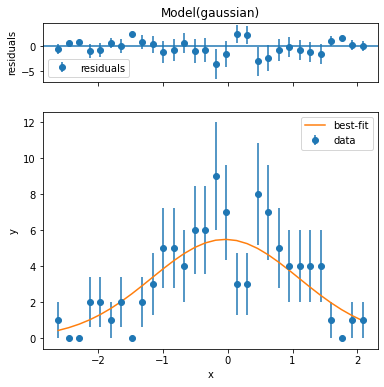

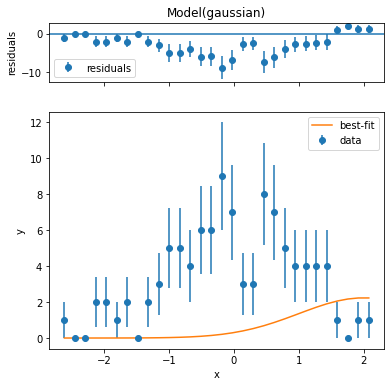

In [11]:
#with Bayesian, we hypothesize a guassian and fit it
from lmfit.models import GaussianModel
#randomly sample 100 events froma. gaussian
lN=100
samples = np.random.normal(0,1,lN)
#make a histogram
count, bins, ignored = plt.hist(samples,30)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
#poisson unc.
weight=1./np.sqrt(count)
weight[weight==float('+inf')] = 0
plt.show()

#Now we can consider two ways to interpret the data
def frequentist(iBins,iCount,weight): #fit a gaussian float all parameters
    model = GaussianModel()
    params = model.make_params(center=2, amplitude=1, sigma=1) 
    result = model.fit(iCount, params, x=iBins,weights=weight)
    result.plot()
    print(result.fit_report())
    
def bayesianBad(iBins,iCount,weight):#fit a gaussian fix the mean and sgima
    model = GaussianModel()
    params = model.make_params(center=2, amplitude=1, sigma=1) 
    params['center'].vary=False
    params['sigma'].vary=False
    result = model.fit(iCount, params, x=iBins,weights=weight)
    result.plot()
    print(result.fit_report())

frequentist(binscenters,count,weight)
bayesianBad(binscenters,count,weight)

From above, what you see is that if we have a sample data, in the frequentist scenario, we just fit this distribution, and extract the parameters. In the frequentist approach, the data is key, and so if our $\chi^{2}$ is good for our fitted model, we can declare success. 

In the Bayesian approach, we need to reocncile our prior with our fitted data. If our prior is that our data should behave as a gaussian about two, and we try to fit it to the data, you see there is not a very good $\chi^{2}$ value, and the fit is clearly off. 

To reconcile our Bayesian fit, what we need to do is modify our model so that we can actually go from our prior to our fitted function. To do this, we need to insert a new prior. In this case, our prior will be that the mean of the Gaussian can vary. Let's write this down. 

\begin{eqnarray}
 P\left(\mathcal{H}=x\right|\mu,\sigma) & = & \mathcal{N}(x,\mu=2,\sigma=1) \\
 P\left(\mathcal{H}=\mu\right|\sigma) & = & \frac{1}{b-a}~\forall~\mu~\in~[a,b] \\ 
                               & = & 0~~~~~~~~~\forall~\mu~\notin~[a,b]
\end{eqnarray}
All that we are saying above is that mu can now vary between a and b. Lets now fit the data with this statement. To do this, we are going to use a new feature in `lmfit`. What we are aroing to do is call `lmfit.minimize` and feed it a modified loss, which we define as `resid` (aka the residual function).

Additionally, we will add another constraint and put it into the fit. In particular, we will add a paramater $\Delta_{\mu}$, such that the loss and $\mu$ will be written as: 
\begin{eqnarray}
\mu_{\rm new} & = & \mu -\Delta_{\mu} \\
\mathcal{L}_{\rm new} & = & \mathcal{L} + 0~\forall~\mu~\in~[a,b] \\ 
                      & = & \mathcal{L} + \inf~\forall~\mu~\notin~[a,b] 
\end{eqnarray}
In this case, we will just approximate a really large number as infinity. 

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 31
    # variables        = 2
    chi-square         = 13.3123133
    reduced chi-square = 0.45904529
    Akaike info crit   = -22.2042314
    Bayesian info crit = -19.3362570
[[Variables]]
    amplitude:  5.96406836 +/- 0.43400749 (7.28%) (init = 1)
    center:     2 (fixed)
    sigma:      1 (fixed)
    fwhm:       2.35482000 +/- 0.00000000 (0.00%) == '2.3548200*sigma'
    height:     2.37931915 +/- 0.17314395 (7.28%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
    deltamu:    2.02765563 +/- 0.08795644 (4.34%) (init = 0)


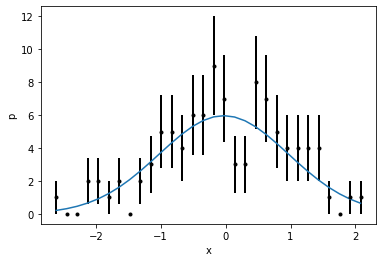

In [13]:
import lmfit
#here is our modified function
def gauss(x, amp, mu, sigma,dmu):
    return amp * np.exp(-(x-mu+dmu)**2 / (2.*sigma**2))

#now we define our loss we want to minimize
def resid(params, x, ydata,weights):
    mu    = params['center'].value
    sigma = params['sigma'].value
    amp   = params['amplitude'].value
    dmu   = params['deltamu'].value
    lossshift=0
    if abs(dmu) > 3:
        lossshift=1e32
    y_model= gauss(x,amp,mu,sigma,dmu)
    residarr = (y_model - ydata)*weights
    #now append our constraint to the loss
    residarr = np.append(residarr,lossshift)
    return residarr
    
def bayesianGood(iBins,iCount,weights):
    model = GaussianModel()
    params = model.make_params(center=2, amplitude=1, sigma=1) 
    params['center'].vary=False
    params['sigma'].vary=False
    params.add("deltamu", value=0.0, min=-10, max=10) #Our new line of code
    result = lmfit.minimize(resid, params, args=(iBins, iCount,weights))
    lmfit.report_fit(result)
    #Now we plot it. 
    plt.errorbar(iBins, iCount,np.sqrt(iCount), lw=2,fmt=".k", capsize=0)
    plt.plot(binscenters,gauss(binscenters,result.params['amplitude'].value,result.params['center'].value,result.params['sigma'].value,result.params['deltamu'].value))
    plt.xlabel("x")
    plt.ylabel("p")
    plt.show()

bayesianGood(binscenters,count,weight)



### 8.4 Nuisance Parameters

Now we get a good fit! However, you might be annoyed, we have now added a parameter. This parameter is often referred to as a [nusiance parameter](https://en.wikipedia.org/wiki/Nuisance_parameter), since its a way to incorporate uncertainty of known parameters into the fit. In order to describe our known uncertainty we modified our loss so that once we are out of our parameter range the loss goes to infinity. This is rather unphysical way to modify our parameters. 

In practice, we tend to add parameters where we know somthing about it. What if for example, we have a different model for the behavior of $\mu$. For example, 

\begin{eqnarray}
 P\left(\mathcal{H}=\mu\right|\sigma) & = & \mathcal{N}(\mu,\mu=2,\sigma_{\mu}=0.15) \\   \end{eqnarray}

What this means is that $\mu$ can vary as a gaussian about $2$ with an uncertainty of $\sigma_{\mu}=0.15$. What we can then do is again add a new parameter $\Delta_{\mu}$, however in this case, we need to modify the loss so that $\Delta_{\mu}$ can only vary as gaussian about 0 (its 0 b/c we are fixing $\mu$ to be 2, but floating $\Delta_{\mu}$. 

The modified loss can be written noting that loss is $-\log($Likelihood$)$, thus: 
\begin{equation}
 \log(P) = \log\left(\mathcal{N}(\Delta_{\mu},\mu=0,\sigma=1)\right)\\
 -\log(P) = -\log\left(\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\left(-\frac{\Delta_{\mu}^2}{2\sigma_{\mu}^{2}}\right) \right) \\
 -\log(P) = -\log(C) + \left(\frac{\Delta_{\mu}^2}{2\sigma_{\mu}^{2}}\right)
\end{equation}

Where $C$ is a constant that we don't care about when minimizing. As a consequence, we can write the modified loss as, and $\Delta_{\mu}$ definition as:

\begin{eqnarray}
\mu_{\rm new} & = & \mu -\Delta_{\mu} \\
\mathcal{L}_{\rm new} & = & \mathcal{L} + \left(\frac{\Delta_{\mu}^2}{2\sigma_{\mu}^{2}}\right)  
\end{eqnarray}

Now lets perform the fit, again and see how we do. Note, that ``lmfit`` when it computes resid, does not square the difference, it computes the signed residual, so we have to be careful to take that into account. 


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 31
    # variables        = 2
    chi-square         = 80.3740576
    reduced chi-square = 2.77151923
    Akaike info crit   = 33.5338318
    Bayesian info crit = 36.4018062
[[Variables]]
    amplitude:  2.45295638 +/- 0.85509787 (34.86%) (init = 1)
    center:     2 (fixed)
    sigma:      1 (fixed)
    fwhm:       2.35482000 +/- 0.00000000 (0.00%) == '2.3548200*sigma'
    height:     0.97858806 +/- 0.34113471 (34.86%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
    deltamu:    0.27056733 +/- 0.23834538 (88.09%) (init = 0)


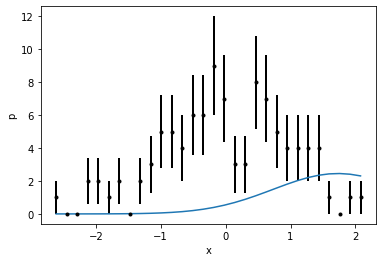

In [14]:
def resid(params, x, ydata,weights):
    mu    = params['center'].value
    sigma = params['sigma'].value
    amp   = params['amplitude'].value
    dmu   = params['deltamu'].value
    #modified loss
    sigmamu=0.15
    lossshift=dmu/sigmamu
    #original loss
    y_model= gauss(x,amp,mu,sigma,dmu)
    residarr = (y_model - ydata)*weights
    #now add the modified loss
    residarr = np.append(residarr,lossshift)
    return residarr

bayesianGood(binscenters,count,weight)

So now the parameter $\Delta_{\mu}$ can move a little bit, but it doesn't really reconcile the fit. If the $\chi^{2}$ is bad then this is a sign that maybe your model is not great, or maybe your uncertainty on $\mu$ (aka $\sigma_{\mu}$) is just too small. 

Now, going back to our original statistical interpretation. Is this bayesian? or is it Frequentists? 

From the above it seems that such an approach is Bayesian. However, the nuisance is now used to profile the data, and yield a better more constrained posterior. So in some other sense we are using the data. In practice, we refer to this as a hybrid approach. Since we are building a Bayesian model, but relying on the data to really get a good fit. To understand this more, lets do a quick challenge question. 

### Challenge Question: 

Take the above distribtuion, which was for 100 events and run the fit now for 1000 events. What happens to the nuisance parameter, and the fit? 


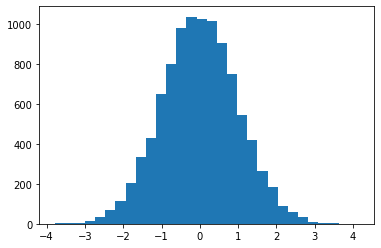

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 31
    # variables        = 2
    chi-square         = 200.979106
    reduced chi-square = 6.93031401
    Akaike info crit   = 61.9456262
    Bayesian info crit = 64.8136007
[[Variables]]
    amplitude:  1054.36832 +/- 27.7933145 (2.64%) (init = 1)
    center:     2 (fixed)
    sigma:      1 (fixed)
    fwhm:       2.35482000 +/- 0.00000000 (0.00%) == '2.3548200*sigma'
    height:     420.632121 +/- 11.0879288 (2.64%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
    deltamu:    1.98710261 +/- 0.02599663 (1.31%) (init = 0)


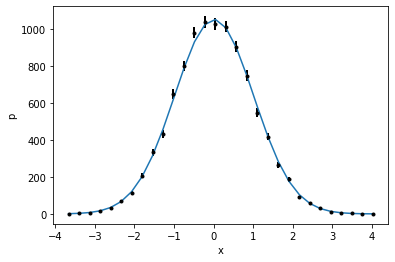

In [15]:
#solution
lN=10000
samples = np.random.normal(0,1,lN)
count, bins, ignored = plt.hist(samples,30)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
weight=1./np.sqrt(count)
weight[weight==float('+inf')] = 0
plt.show()

bayesianGood(binscenters,count,weight)
#The fit is now good.  
#The data now has a much stronger constraint than our nuisance, and as a consequence pulls it away from 2!

### 8.5 Hypothesis tests

Ok, so we have taken a bit of a foray into understanding Bayes theorem and building high level insights into how we build a fit model. In practice, when we build models there are times when we know how our parameters will vary, and there are times when we don't know our parameters. The ones we do, we end up as Bayesians, we try to put gaussian constraints on them. For the ones that we don't, we behave like frequentists, we try to put no constraints and then rely on our knowledge of the data to understand them. 

Even though there is no underlying model, there are many powerful ways to play data off of other data. In its most general form, we can ask are two distributions from the same underlying phenomena, or are they different. This question is often referred to as a "[hypothesis test](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)", since we aim to test the hypothesis of two distributions being the same.  

Lets imagine we have took two measurements of a parameter $x$: $p_{a}(x)$ and $p_{b}(x)$, and we have two hypotheses

**Null Hypothesis** the distributions are the same $p_{a}(x) = p_{b}(x)$. 

**Alternative Hypothesis** the distributions are different $p_{a}(x) \neq p_{b}(x)$ 

In this case, we would like to compute the probability ($p$) of either the **Null** being true or the **Alternative** ($1-p$). From this p-value we can translate this to a confidence interval that will gauge our likelihood to believe our hypothesis. 

There are many uses of a hypothesis test in physics, and beyond. To give you a few examples: 

**Is my data consistent?** Let's say you took some data, perhaps you measured some astrophysical phenonmenon twice, and you would like to determine that the measurement is the same in both instances, then you can perform a hypothesis test. 

**Can I detect an effect?** Famously, one of the great statistician's, Fisher, [constructed a hypothesis test to test a lady's claim that she could determine, just by taste, wether tea was prepared by pouring the tea into the milk vs pouring the milk into the tea](https://en.wikipedia.org/wiki/Lady_tasting_tea). We could imagine all sorts of effects in the data that we would like to test. 

**Did I Just make a discovery?** In the rest of the lecture, and next lecture, we are going to build up the fit that led to the discovery of the Higgs boson. We will evaluate the significance by making a hypothesis test. 

### 8.6 $\chi^{2}$ test

The most basic hypothesis test is to make two histograms, and compute the distribution bin by bin, by computing the $\chi^{2}$ metric between the two distributions.  To see this, lets again make two gaussian distributions, we will sample two distributions: 

\begin{equation}
 p_{a} (x) = \mathcal{N}(x,\mu=0,\sigma=1)\\
 p_{b} (x) = \mathcal{N}(x,\mu=0.2,\sigma=1)
\end{equation}

Let's sample each distribution 50 times. 


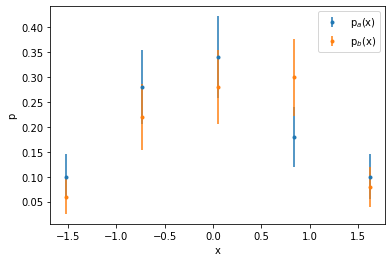

In [34]:
testSamplesA = np.random.normal(0  ,1, 50)
testSamplesB = np.random.normal(0.2,1, 50)

def plotHist(iSamples,iLabel,bin_edges=None):
    if bin_edges is None:
        y, bin_edges = np.histogram(iSamples, bins=5)
    else:
        y, bin_edges = np.histogram(iSamples, bins=bin_edges)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    norm=len(iSamples)
    plt.errorbar(bin_centers,y/norm,yerr=y**0.5/norm,fmt=".",label=iLabel)
    return bin_edges

bin_edges=plotHist(testSamplesA,"p$_{a}$(x)")
bin_edges=plotHist(testSamplesB,"p$_{b}$(x)",bin_edges)
plt.xlabel("x")
plt.ylabel("p")
plt.legend()
plt.show()

We can define a $\chi^{2}$ compatability test by reminding ourselves that a $\chi^{2}$ is a sum of Gaussian distribtuions with width $1$. Let's imagine that we believe our first measurement is emblemeatic of a true distributions $p_{a}(x)$, and then we compare a new observation $\mathcal{O}_b$, which is our measured distributions from $p_{b}$, we can define a $\chi^{2}$ between the two as:

\begin{eqnarray}
\chi^{2}_{N_{bins}} & = & \sum_{i=1}^{N_{bins}} \left(\frac{\mathcal{O}_{b}(x_{i}) - p_{a}(x_{i}) }{\sigma_{i}}\right)^{2} 
\end{eqnarray}

For a first measurement of $N_{a}$ events and $N_{a}(x_{i})$ events for the $x_{i}^{th}$ bin, we can write $p_{a}(x)$ as:
\begin{equation}
 p_{a}(x_{i}) = \frac{1}{N_{a}}\left(N_{a}(x_{i})\right)
\end{equation}

Consequently the uncertainty in each bin is
\begin{eqnarray}
\sigma_i&=&\sqrt{\sigma^2_a(x_{i})+\sigma^2_{b}(x_{i})}\\
\sigma_i&=&\sqrt{\frac{1}{N^{2}_{a}} N_{a}(x_{i})+\frac{1}{N^{2}_{b}} N_{b}x_{i}))}\\
\sigma_i&=&\sqrt{\frac{p_{a}(x_{i})}{N_{a}}+\frac{p_{a}(x_{i})}{N_{b}}}
\end{eqnarray}
we can write the above $\chi^{2}$ test as (for $N_{a} \gg N_{b}$)

\begin{eqnarray}
\chi^{2}_{N_{bins}} & = & \sum_{i=1}^{N_{bins}} \frac{\left(p_{b}(x_{i}) - p_{a}(x_{i})\right)^{2}  }{\frac{p_{a}(x_{i})}{N_{a}} + \frac{p_{b}(x_{i})}{N_{b}} } \\
& \approx & N_{b} \sum_{i=1}^{N_{bins}} \frac{\left(p_{b}(x_{i}) - p_{a}(x_{i})\right)^{2}  }{p_{b}(x_{i})}\\
                    & = & N_{b} \sum_{i=1}^{N_{bins}} \frac{\left(\frac{N_{b}(x_{i})}{N_{b}} - p_{a}(x_{i})\right)^{2}  }{p_{b}(x_{i})}
\end{eqnarray}

Since this is a $\chi^{2}$ distribution, we can immediately determine the significance by translating the $\chi^{2}$ value to a p-value. Let's code this up! One thing to note is that this test doesn't depend on the sampling in $b$, so it has its limitations. Oftentimes, we use this when $N_{a} \gg N_{b}$, this is the reason for the approximation in the above form.


0.9335563963335675


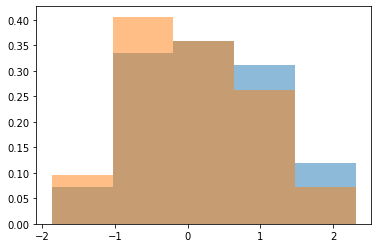

In [18]:
def chi2test(iSampleB,iSampleA,nbins=5):
    countA, binsA, ignored = plt.hist(iSampleA, nbins,      density=True ,alpha=0.5,label='a')
    countB, binsB, ignored = plt.hist(iSampleB, bins=binsA, density=True,alpha=0.5,label='b')
    #plt.legend()
    #plt.xlabel("x")
    #plt.ylabel("p")
    chi2=0
    ndof=0
    for i0 in range(len(binsA)-1):
        if countB[i0] > 0 and countA[i0] > 0:
            unc2 = countA[i0]/len(iSampleA) +  countB[i0]/len(iSampleB)
            chi2+=(countB[i0]-countA[i0])**2/unc2
            ndof=ndof+1
    #now we reply on the chi2 distribution to get the probabiliy
    p=1-stats.chi2.cdf(chi2, ndof)
    return p
print(chi2test(testSamplesA,testSamplesB))

So,as you can see our data deviations by a fairly large p-value. Let's take a look at how this varies over the number of events for 3 different distributions, one with $\mu=0.2$, one with $\mu=1$ and $\mu=2$ going from a sample of $0$ to $50$ events, and comparing to a true distribution of 100k events. 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


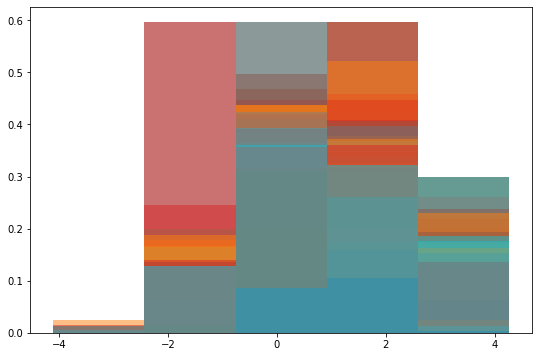

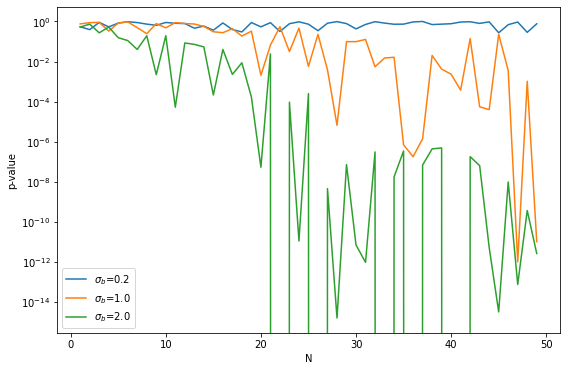

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fast')
#baseline
samples = np.random.normal(0,1, 100000)

xvals=[]
pvalues1=[]
pvalues2=[]
pvalues3=[]
for i0 in range(50):
    #0.2
    testsamples1 = np.random.normal(0.2,1, i0)
    pvalue = chi2test(testsamples1,samples)
    pvalues1.append(pvalue)
    #1
    testsamples2 = np.random.normal(1,1, i0)
    pvalue = chi2test(testsamples2,samples)
    pvalues2.append(pvalue)
    #3
    testsamples3 = np.random.normal(2,1, i0)
    pvalue = chi2test(testsamples3,samples)
    pvalues3.append(pvalue)
    #x-axis
    xvals.append(i0)
count1, bins1, ignored = plt.hist(samples, 5, density=True,alpha=0.5)
plt.show()
    
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fast')
ax.plot(xvals,pvalues1,label='$\sigma_{b}$=0.2')
ax.plot(xvals,pvalues2,label='$\sigma_{b}$=1.0')
ax.plot(xvals,pvalues3,label='$\sigma_{b}$=2.0')
ax.set_xlabel('N')
ax.set_ylabel('p-value')
ax.set_yscale('log')
ax.legend()
plt.show()


So you can see that for 50 events, its hard to distinguish the small $\sigma$. However for a 2 $\sigma$, we can pretty clearly separate them with with more than 10 events. The above is fluctuating a lot b/c it is just one scan. In principle, to get a trend line, we would have to run the above plot many times and then average over the many plots to get a nice trend line. 

### Challenging Challenge question (after class)

Compute the trend line above the above distribution by running the above plot 50 times and taking the average p-value. This may take a while. 

/Users/pharris/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


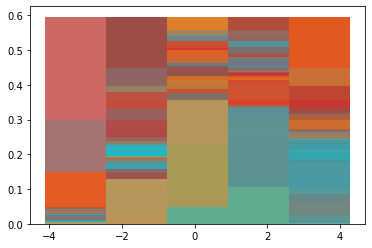

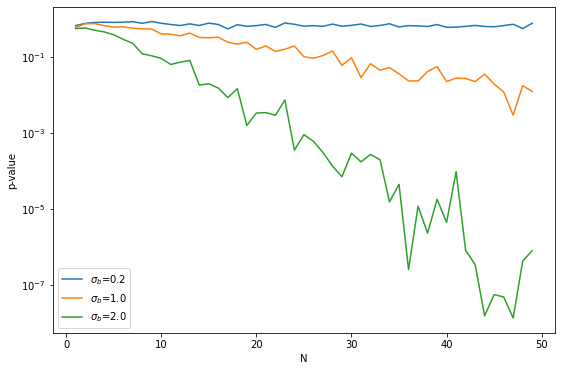

In [21]:
#solution
def scan(iN,iNToys=30): 
    spvalues1=np.array([])
    spvalues2=np.array([])
    spvalues3=np.array([])
    for i0 in range(iNToys):
        testsamples1 = np.random.normal(0.2,1,iN)
        pvalue = chi2test(testsamples1,samples)
        spvalues1 = np.append(spvalues1,pvalue)
        
        testsamples2 = np.random.normal(1,1, iN)
        pvalue = chi2test(testsamples2,samples)
        spvalues2 = np.append(spvalues2,pvalue)
        
        testsamples3 = np.random.normal(2,1, iN)
        pvalue = chi2test(testsamples3,samples)
        spvalues3 = np.append(spvalues3,pvalue)
    return spvalues1.mean(),spvalues2.mean(),spvalues3.mean()
        
xvals=[]
pvalues1=[]
pvalues2=[]
pvalues3=[]
for i0 in range(50):
    xvals.append(i0)
    tmppvalue1,tmppvalue2,tmppvalue3=scan(i0)
    pvalues1.append(tmppvalue1)
    pvalues2.append(tmppvalue2)
    pvalues3.append(tmppvalue3)

fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fast')
ax.plot(xvals,pvalues1,label='$\sigma_{b}$=0.2')
ax.plot(xvals,pvalues2,label='$\sigma_{b}$=1.0')
ax.plot(xvals,pvalues3,label='$\sigma_{b}$=2.0')
ax.set_xlabel('N')
ax.set_ylabel('p-value')
ax.set_yscale('log')
ax.legend()
plt.show()

## 8.7 Komogorov-Smirnov Test

In addition to doing a $\chi^{2}$-test, there is another test to compare distributions, known as teh Kolmogorov-Smirnov test, or the KS-test. This is defined as the maximum difference in the CDFs of the two distributions. Its is another way to compare two distributions. 


0.44000000000000006


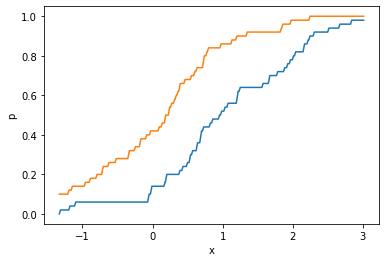

In [14]:
def KStest(iSampleB,iSampleA,nbins=5):
    #sort generated array
    sortSampleA = np.sort(iSampleA)
    sortSampleB = np.sort(iSampleB)    
    xrange=np.linspace(sortSampleA[0],sortSampleA[-1],1000)
    cdfA=np.array([])
    cdfB=np.array([])
    for x in xrange:
        cdfA = np.append(cdfA,len(sortSampleA[sortSampleA < x])/len(sortSampleA))
        cdfB = np.append(cdfB,len(sortSampleB[sortSampleB < x])/len(sortSampleB))
    plt.plot(xrange,cdfA)
    plt.plot(xrange,cdfB)
    plt.xlabel("x")
    plt.ylabel("p")
    ks=np.max(np.abs(cdfA-cdfB))
    return ks
print(KStest(testSamplesA,testSamplesB))

### Challenge question
Compute the ks test for two gaussian sampled distributions each with $\sigma=1$, one with mean $\mu=0$ and the other with mean $\mu=1.0$. 

0.42000000000000004


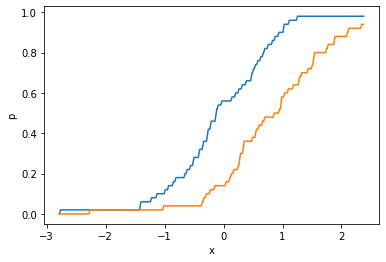

In [16]:
testSamplesA = np.random.normal(0  ,1, 50)
testSamplesB = np.random.normal(1.0,1, 50)
print(KStest(testSamplesB,testSamplesA))

## 8.8.1 Maximum Likelihood

Lets say we have a sample that is Gaussian distributed, and we want to find the maximum likelhiood value of the mean and the resolution of this sample. 

For this sample, we can write, the likelhiood and log likelihood as:  

\begin{equation}
\mathcal{L}(x|\mu_{i},\sigma_{i}) = \left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{N} \exp\left(-\sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{2\sigma^{2}}\right)\\
\log\left(\mathcal{L}(x|\mu_{i},\sigma_{i}) \right) =  -\frac{n}{2}\log\left(2\pi\sigma^{2}\right) - \sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{2\sigma^{2}}
\end{equation}

To get get maximum value of $\mu$ we can write: 

\begin{eqnarray}
\frac{\partial}{\partial \mu}\log\left(\mathcal{L}(x|\mu_{i},\sigma_{i}) \right) & = & \frac{\partial}{\partial \mu} \left( -\frac{n}{2} \log\left(2\pi\sigma^{2}\right) - \sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{2\sigma^{2}} \right)  = 0\\
& = &  \left( \sum_{i=0}^{N} \frac{(x_{i}-\mu)}{\sigma^{2}} \right)  = 0\\
\sum_{i=0}^{N} (x_{i}-\hat{\mu}) & = & 0 \\
\sum_{i=0}^{N} x_{i} - N \hat{\mu} & = & 0 \\
\end{eqnarray}

This gives us a best fit for $\mu$, given by $\hat{\mu}$ of
\begin{eqnarray}
\hat{\mu} & = & \frac{1}{N} \sum_{i=0}^{N} x_{i}
\end{eqnarray}

Now for $\sigma^{2}$, we can do the same thing, and we get (for a best fit $\hat{\sigma}^{2}$:  

\begin{eqnarray}
\frac{\partial}{\partial \sigma^{2}}\log\left(\mathcal{L}(x|\mu_{i},\sigma_{i}) \right) & = & \frac{\partial}{\partial \sigma^{2}} \left( -\frac{n}{2} \log\left(2\pi\sigma^{2}\right) - \sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{2\sigma^{2}} \right)  = 0 \\
& = & \left( -\frac{n}{2\hat{\sigma}^{2}} +  \sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{2\hat{\sigma}^{4}} \right) \\
0 & = & \left( -n +  \sum_{i=0}^{N} \frac{(x_{i}-\mu)^2}{\hat{\sigma}^{2}}\right) \\
\hat{\sigma}^{2} & = & \frac{1}{n} \sum_{i=0}^{N}(x_{i}-\mu)^2  
\end{eqnarray}
 
Now none of this is a big surprise, the best fit for the mean and variance of a gaussian distribution is the mean and variance. However, this process shows you the thought process that is undergone when trying to construt a maximum likelihood estimator of a sample. 


## 8.8.2 Likelihood Ratio

The most powerful way to compare two distributions is to compute the likelihood of each, and then take their ratio. By taking the $\log$ of this ratio, we end up with a robust way to define a hypothesis test. 
We define this as 
\begin{eqnarray}
\lambda & = & -2 \log\left(\frac{\mathcal{L_{\rm null}}}{\mathcal{L_{\rm alternative}}}\right) \\
        & = & -2 \log\left(\mathcal{L_{\rm null}}\right) - \log\left(\mathcal{L_{\rm alternative}}\right)  
\end{eqnarray}

Recall that the likelihood is just the probability of a specific thing happening. The likelihood ratio is just the ratio of the maximum probabilities of two hypotheses. Lets do an analytic example to start with. Imagine you have a set of points $x_{i}$, and you want to test the hypothesis that this sample has mean $\mu_{0}$ vs the alternative hypothesis that the mean is $\neq \mu_{0}$. Lets write out the likelihood for both scenarios. 

**Hypothesis $\mu_{0}$**

The likelihood is just written following the form below as: 
\begin{equation}
\mathcal{L}(\mu_{i}|x_{i},\sigma_{i}) = \left(\frac{1}{\sqrt{2\pi\sigma^{2}}}\right)^{N} \exp\left(-\sum_{i=0}^{N} \frac{(x_{i}-\mu_{0})^2}{2\sigma^{2}}\right)\\
\log\left(\mathcal{L}(x|\mu_{0},\sigma_{i}) \right) =  -\frac{n}{2}\log\left(2\pi\sigma^{2}\right) - \sum_{i=0}^{N} \frac{(x_{i}-\mu_{0})^2}{2\sigma^{2}}
\end{equation}

Now, since we are maximizing all of our parameters except for $\mu$. The parameter $\sigma$ will be maximized to be the optimized value of $\sigma$, we denote $\hat{\sigma}$.

\begin{eqnarray}
\hat{\sigma}_{\mu}^{2} & = & \frac{1}{n} \sum_{i=0}^{N}(x_{i}-\mu_{0})^2  
\end{eqnarray}

which means, we can write the above as
\begin{equation}
\log\left(\mathcal{L}(x|\mu_{0},\sigma_{i}) \right) =  -\frac{n}{2}\left(\log\left(2\pi\hat{\sigma}_{\mu}^{2}\right) + 1\right)
\end{equation}

Finally, one more relation that is useful is that if $\mu_{0}\neq\bar{x}$, we can write this as 

\begin{eqnarray}
\hat{\sigma}^{2} & = & \frac{1}{n} \sum_{i=0}^{N} \left(x_{i} - \bar{x} + \bar{x}-\mu_{0}\right)^{2} \\ 
                 & = & \frac{1}{n} \sum_{i=0}^{N} \left(\left(x_{i} - \bar{x}\right)^2 + \left(\bar{x}-\mu_{0}\right)^{2} + 2(x_{i} - \bar{x})(\bar{x}-\mu_{0})\right) \\ 
                 & = & \frac{1}{n} \sum_{i=0}^{N} \left(\left(x_{i} - \bar{x}\right)^2 + \left(\bar{x}-\mu_{0}\right)^{2}\right) \\
                 & = & \hat{\sigma}^{2} +  \left(\bar{x}-\mu_{0}\right)^{2}
\end{eqnarray}


**Alternative Hypothesis $\mu\neq\mu_{0}$**

In this scenario, we want to compute the maximum likelihood over *all parameters*, above we fixed $\mu$. This we can write, noting $\hat{\mu}_{max}=\bar{x}$.

\begin{equation}
\mathcal{L}(\mu_{i}\neq\mu_{0}|x_{i},\mu_{i},\sigma_{i}) = \left(\frac{1}{\sqrt{2\pi\hat{\sigma}^{2}}}\right)^{N} \exp\left(-\sum_{i=0}^{N} \frac{(x_{i}-\bar{x})^2}{2\hat{\sigma}^{2}}\right)\\
\log\left(\mathcal{L}(x|\mu_{0},\hat{\sigma}_{i}) \right) =  -\frac{n}{2}\log\left(2\pi\hat{\sigma}^{2}\right) - \sum_{i=0}^{N} \frac{(x_{i}-\bar{x})^2}{2\hat{\sigma}^{2}} \\
\log\left(\mathcal{L}(x|\mu_{0},\hat{\sigma}_{i}) \right) =  -\frac{n}{2}\left(\log\left(2\pi\hat{\sigma}^{2}\right) + 1\right)
\end{equation}

The log likelihood ratio for these is 

\begin{eqnarray}
\lambda & = & -n\left(\log\left(2\pi\hat{\sigma}^{2}\right) + 1\right) + n\left(\log\left(2\pi\hat{\sigma}_{\mu}^{2}\right) + 1\right) \\
        & = & n \log\left(\frac{\hat{\sigma}^{2}_{\mu}}{\hat{\sigma}^{2}}\right) \\
        & = & n \log\left(\frac{\hat{\sigma}^{2} +  \left(\bar{x}-\mu_{0}\right)^{2}}{\hat{\sigma}^{2}}\right)\\
        & = & n \log\left(1+ \frac{\left(\bar{x}-\mu_{0}\right)^{2}}{\hat{\sigma}^{2}}\right)\\
        & \approx & n \frac{\left(\bar{x}-\mu_{0}\right)^{2}}{\hat{\sigma}^2} 
\end{eqnarray}
Where in the last step, we taylor expanded for small $|\mu_{0}-\bar{x}|$. Incidently, if we had done a $\chi^{2}$ test we would converge on the same thing:
\begin{eqnarray}
\lambda & = & \sum_{i=0}^{N} \frac{(x_{i}-\mu_{0})^2}{\hat{\sigma}^{2}} - \frac{(x_{i}-\bar{x})^2}{\hat{\sigma}^{2}} \\
        & = & \frac{1}{\hat{\sigma}^2} \sum_{i=0}^{N} \left(x_{i}-\mu_{0}\right)^2 - \left(x_{i}-\bar{x}\right)^2 \\
        & = & \frac{1}{\hat{\sigma}^2} \sum_{i=0}^{N} x^{2}_{i} - x^{2}_{i} - 2 x_{i}\left(\mu_{0}-\bar{x}\right) - \mu_{0}^2 -\bar{x}^2 \\
        & = & \frac{1}{\hat{\sigma}^2} \sum_{i=0}^{N} \left(\mu_{0}-\bar{x}\right)^{2} \\
        & = & \frac{n}{\hat{\sigma}^2} \left(\mu_{0}-\bar{x}\right)^{2}
\end{eqnarray}

For both cases, what we see is that in this scenario, we have that our likelihood ratio is exactly equivalent to a gaussian distribution about $\mu=\bar{x}$, with a variance given by $\hat{\sigma}^2/n$. 

Imagine now we had this for a few bins with mean in each of them given by $\bar{x}_{i}$, if we considered a few different samples (for example bins in a histogram), we can write this by just adding a summation: 
\begin{eqnarray}
\lambda & = & \sum_{i=0}^{N_{\rm bins}} \frac{n_{i}}{\hat{\sigma}_{i}^2} \left(\mu_{i}-\bar{x}_{i}\right)^{2}
\end{eqnarray}

This is very similar to a $\chi^{2}$ test.  More generally, this is a sum of gaussian variables $\mu_{i}$, which means that the variation of the log likelihood is going to follow a $\chi_{\nu}$ distribution with $\nu=N_{\rm bins}$ as the number of degrees of freedom. 

### Wilk's theorem
This yields Wilk's theorem again, which says that the likelihood ratio $\lambda\rightarrow\chi_{\nu}$ in the limit of $n\rightarrow\infty$. 

Let's show Wilk's theorem

4.887208541554855


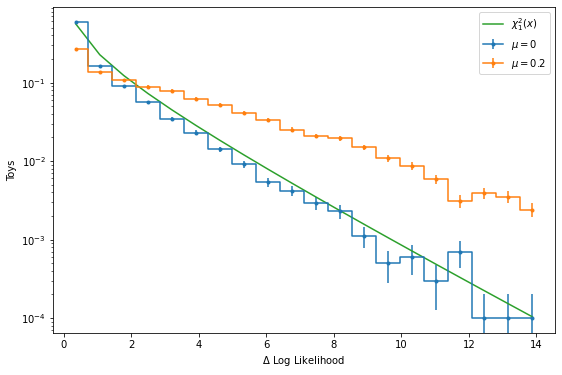

In [43]:
#Now lets run a simulation to see if Wilk's theorem is true
#Lets define the log likelihood is the simplest way possible (assume we don't know math)
#note we will use -1 to compute these on the fly
def loglikelihoodGaus(isample,mu0=-1,sigma0=-1):
    n=len(isample)
    if mu0 == -1:
        mu0=isample.mean()
    if sigma0 == -1:
        sigmahat2=(isample-mu0)**2/len(isample)
        sigmahat2=sum(sigmahat2)
    val=-n/2*(np.log(2*np.pi*sigmahat2)+1)
    return val

hypoth=loglikelihoodGaus(testSamplesB,0) #compute with a fixed mean of 0
null  =loglikelihoodGaus(testSamplesB) #compute with mean floating
val=-2*(hypoth-null)
print(val)

def sampleGaus(iMean,iNToy=10000):
    ntoys=iNToy
    deltaLL=[]
    for i0 in range(ntoys):
        testsamples1 = np.random.normal(iMean,1, 50)
        hypoth=loglikelihoodGaus(testsamples1,0) #compute with a fixed mean of 0
        null  =loglikelihoodGaus(testsamples1) #compute with mean floating
        val=hypoth-null
        deltaLL.append(-2*val)
    return deltaLL

deltaLL1 = sampleGaus(0)
deltaLL2 = sampleGaus(0.2)
    
y1, bin_edges = np.histogram(deltaLL1, bins=20)
y2, bin_edges = np.histogram(deltaLL2, bins=bin_edges)

#Now plot a chi2 with 1 dof
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
chi2 = []
for x in bin_centers:#range(len(bin_centers)):
    chi2val=stats.chi2.pdf(x, 1)
    chi2.append(chi2val)

#And Draw
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fast')
plt.errorbar(bin_centers,y1/len(deltaLL1),yerr=y1**0.5/len(deltaLL1),marker='.',drawstyle = 'steps-mid',label='$\mu=0$')
plt.errorbar(bin_centers,y2/len(deltaLL2),yerr=y2**0.5/len(deltaLL2),marker='.',drawstyle = 'steps-mid',label='$\mu=0.2$')
plt.plot(bin_centers,chi2,label='$\chi^{2}_{1}(x)$')
plt.xlabel("$\Delta$ Log Likelihood")
plt.ylabel("Toys")
ax.set_yscale('log')
plt.legend()
plt.show()


Now lets consider doing our test with a more realistic example. What if we want to quote the significance of an excess on top of data. Lets take a look at what this would look like. Lets make some toy datat with an excess on top of it. 

No handles with labels found to put in legend.


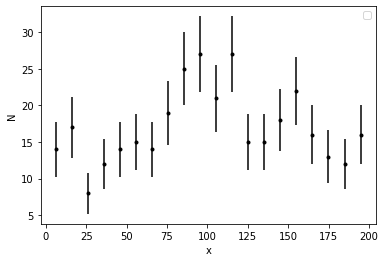

In [92]:
#First lets make a data sample and fit it
bkg = np.random.uniform(0,200, 300)
sig = np.random.normal (100,15,40)
data = np.append(sig,bkg)
y, bin_edges = np.histogram(data, bins=20)
ys, bin_edges = np.histogram(sig, bins=bin_edges)
yb, bin_edges = np.histogram(bkg, bins=bin_edges)

bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.errorbar(bin_centers, y,yerr= y**0.5,marker='.',linestyle = 'None', color = 'black')
#plt.errorbar(bin_centers,yb,yerr=ys**0.5,marker='.',linestyle = '-', color = 'red',label='bkg')
#plt.errorbar(bin_centers,ys,yerr=yb**0.5,marker='.',linestyle = '-', color = 'blue',label='signal')
plt.xlabel("x")
plt.ylabel("N")
plt.legend()
plt.show()

Let's try to fitting our bump distribution. For this, we can define the two fit functions:

**Null hypothesis** Our fit function is just a flat constant with a gaussian signal on top.
\begin{equation}
f(x|C,\mu\,\sigma) = C + \mathcal{N}(x,\mu,\sigma)
\end{equation}

**Alternative hypothesis** Our fit function is just a flat constant
\begin{equation}
f(x|C) = C 
\end{equation}

For each of these we can define the likelihood by summing over our $N$ bins with value $x_{i}$ and number of events $y_{i}$ and treating each bin as a separate gaussian with uncertainty given by the $\sigma_{i}=\sqrt{y_{i}}$. We can write this as

\begin{eqnarray}
 \mathcal{L}(\theta_{i} | x_{i},y_{i}) & = & \prod_{i=0}^{N}\frac{1}{\sqrt{2\pi\sigma_{i}^{2}}}\exp\left(-\sum_{i=0}^{N} \frac{(y_{i}-f(x_{i})^2}{2\sigma_{i}^{2}}\right) \\
 \log\left(\mathcal{L}(\theta_{i} | x_{i},y_{i})\right) & = &  -\sum_{i=0}^{n}\log\left(2\pi\sigma_{i}^{2}\right) - \sum_{i=0}^{N} \frac{(y_{i}-f(x_{i}|\theta_{i}))^2}{2\sigma_{i}^{2}}
\end{eqnarray}

Our liklihood ratio is then just the difference where we replace $f(x)$ with the appropriate hypothesis. Lets write this all out in lmfit and do it. 


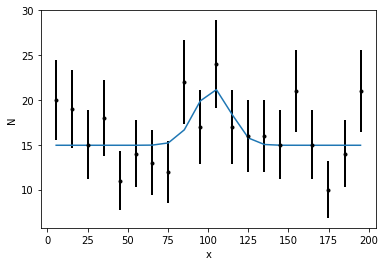

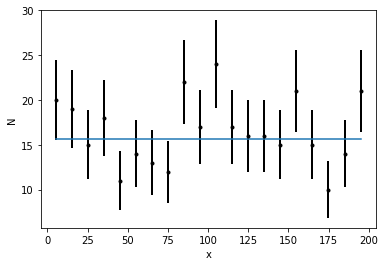

Delta negative Log Likelihood: 1.6161804947111875


In [87]:
from scipy.stats import norm
import lmfit

def fNull(params,x):
    val = norm.pdf(x,params["mu"],params["sigma"])
    return params["amp"]*val + params["c"]

def fAlt(params,x):
    return params["c"]*(x+1)/(x+1) #hack to output array

def binnedLikelihood(params, x, ydata, weights, func):
    y_model= func(params,x)
    residarr = np.sqrt(((y_model - ydata)/(2*weights))**2 + np.log(2*np.pi*weights**2))
    return residarr

def fitData(iX,iY,iFunc,iPlot=False):
    params = lmfit.Parameters()
    params.add('c',    value=1,min=0,max=np.inf)
    params.add('mu',   value=100,min=0,max=200)
    params.add('sigma',value=10,min=0,max=200)
    params.add('amp',  value=20,min=0,max=np.inf)
    result = lmfit.minimize(binnedLikelihood, params, args=(iX,iY,(iY**0.5),iFunc))
    #lmfit.report_fit(result)
    if iPlot:
        #Now we plot it. 
        plt.errorbar(iX, iY,np.sqrt(iY), lw=2,fmt=".k", capsize=0)
        plt.plot(iX,iFunc(result.params,iX))
        plt.xlabel("x")
        plt.ylabel("N")
        plt.show()
    return result.residual

def deltaNLL(x,y,iPlot=False):
    LLNull=fitData(x,y,fNull,iPlot)
    LLAlt=fitData(x,y,fAlt,iPlot)
    return 2.*(np.sum(LLAlt*LLAlt)-np.sum(LLNull*LLNull))

x=bin_centers
NLL = deltaNLL(x,y,True)
print("Delta negative Log Likelihood:",NLL)

Ok, so we got a big delta log likelihood. However, what is the significance of this? 

Well, this is where we can invoke Wilks' therorem. $\Delta \log(\mathcal{L})$ will be $\chi^{2}$ distributed if the null and alternative hypothesed are the same. In this case, the $\chi^{2}$ distribution will be with $n_{\rm params~Null}-n_{\rm params~Alt}$ degrees of freedom. For this case its $3$ (ie the 3 gaussian parameters. 

To see what this would look like if we just fit background, lets run the above computation for 1000 toys of just background data. 

Toy: 0  of  500
Toy: 50  of  500
Toy: 100  of  500
Toy: 150  of  500
Toy: 200  of  500
Toy: 250  of  500
Toy: 300  of  500
Toy: 350  of  500
Toy: 400  of  500
Toy: 450  of  500
Significance with 3 floating 0.9465427651601503


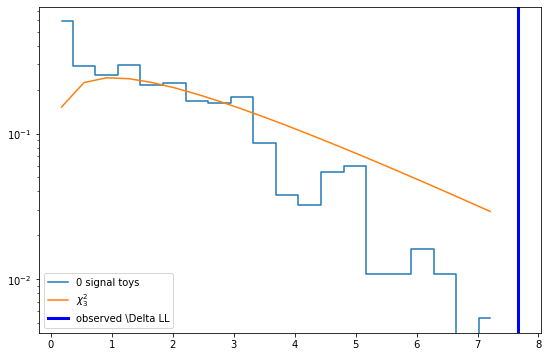

In [96]:
def toyNLL(iNEvents,iNToys,iBin_Edges):
    deltaNLLArr=np.array([])
    for i0 in range(iNToys):
        if i0 % 50 == 0:
            print("Toy:",i0," of ",iNToys)
        bkg = np.random.uniform(0,200, iNEvents)
        y, bin_edges = np.histogram(bkg, bins=iBin_Edges)
        x = 0.5*(bin_edges[1:] + bin_edges[:-1])
        nll = deltaNLL(x,y)
        deltaNLLArr=np.append(deltaNLLArr,nll)
    return deltaNLLArr

NLL1 = toyNLL(300,500,bin_edges)
ll1, ll_bin_edges = np.histogram(NLL1, bins=20,density=True)
ll_bin_centers = 0.5*(ll_bin_edges[1:] + ll_bin_edges[:-1])
chi21 = np.array([])
for x in ll_bin_centers:#range(len(bin_centers)):
    chi2val=stats.chi2.pdf(x, 3) #len is to normalize
    chi21 = np.append(chi21,chi2val)

fig, ax = plt.subplots(figsize=(9,6))
plt.plot(ll_bin_centers,ll1,drawstyle = 'steps-mid',label='0 signal toys')
plt.plot(ll_bin_centers,chi21,label='$\chi^{2}_{3}$')
ax.axvline(x=NLL,linewidth=3,c='b',label="observed \Delta LL")
print("Significance with 3 floating",stats.chi2.cdf(NLL,3))
plt.legend()
plt.yscale('log')
plt.show()

### challenge question

Run the fit toys for the above distribution, fixing the mass of the gaussian in the fit. What $\chi^{2}$ distribution is run? 

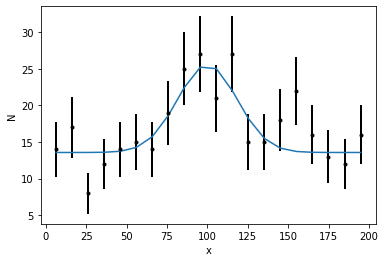

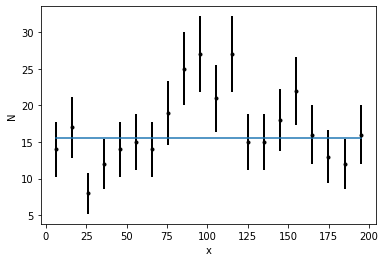

Delta negative Log Likelihood: 7.6231207450097145
Our Probability of this happening 0.02211364649631775


In [93]:
def fitData(iX,iY,iFunc,iPlot=False):
    params = lmfit.Parameters()
    params.add('c',    value=1,min=0,max=np.inf)
    params.add('mu',   value=100,min=0,max=200)
    params.add('sigma',value=10,min=0,max=200)
    params.add('amp',  value=20,min=0,max=np.inf)
    params["mu"].vary = False
    result = lmfit.minimize(binnedLikelihood, params, args=(iX,iY,(iY**0.5),iFunc))
    #lmfit.report_fit(result)
    if iPlot:
        #Now we plot it. 
        plt.errorbar(iX, iY,np.sqrt(iY), lw=2,fmt=".k", capsize=0)
        plt.plot(iX,iFunc(result.params,iX))
        plt.xlabel("x")
        plt.ylabel("N")
        plt.show()
    return result.residual

def deltaNLL(x,y,iPlot=False):
    LLNull=fitData(x,y,fNull,iPlot)
    LLAlt=fitData(x,y,fAlt,iPlot)
    return 2.*(np.sum(LLAlt*LLAlt)-np.sum(LLNull*LLNull))

x=bin_centers
NLL = deltaNLL(x,y,True)
print("Delta negative Log Likelihood:",NLL)
stats.chi2.pdf(x, 3)

probability = 1-stats.chi2.cdf(NLL, 2)
print("Our Probability of this happening",probability)

Toy: 0  of  500
Toy: 50  of  500
Toy: 100  of  500
Toy: 150  of  500
Toy: 200  of  500
Toy: 250  of  500
Toy: 300  of  500
Toy: 350  of  500
Toy: 400  of  500
Toy: 450  of  500
Significance with 3 floating 0.97834904386565


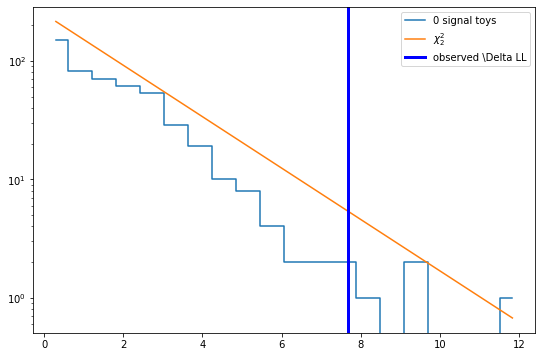

In [94]:
#answer
def fitData(iX,iY,iFunc,iPlot=False):
    params = lmfit.Parameters()
    params.add('c',    value=1,min=0,max=np.inf)
    params.add('mu',   value=100,min=0,max=200)
    params.add('sigma',value=10,min=0,max=200)
    params.add('amp',  value=20,min=0,max=np.inf)
    params['mu'].vary = True    ###############!!!! this is what we fix
    result = lmfit.minimize(binnedLikelihood, params, args=(iX,iY,(iY**0.5),iFunc))
    return result.residual

NLL = deltaNLL(x,y,True)
NLL1 = toyNLL(300,500,bin_edges)
ll1, ll_bin_edges = np.histogram(NLL1, bins=20)
ll_bin_centers = 0.5*(ll_bin_edges[1:] + ll_bin_edges[:-1])
chi21 = np.array([])
for x in ll_bin_centers:#range(len(bin_centers)):
    chi2val=stats.chi2.pdf(x, 2)*len(NLL1) #len is to normalize
    chi21 = np.append(chi21,chi2val)

fig, ax = plt.subplots(figsize=(9,6))
plt.plot(ll_bin_centers,ll1,drawstyle = 'steps-mid',label='0 signal toys')
plt.plot(ll_bin_centers,chi21,label='$\chi^{2}_{2}$')
ax.axvline(x=NLL,linewidth=3,c='b',label="observed \Delta LL")
print("Significance with 3 floating",stats.chi2.cdf(NLL,2))
plt.legend()
plt.yscale('log')
